## Ensemble methods
### Combiding models together to improve performance
### Can act as regularization
### With decision trees, provides the closest thing to "It just works" algorithm for a diversity of cases

There are three main ways of aggregating models:
- **bagging**: train multiple copies of the same model on randomly subsamples datasets, average their output
- **boosting**: train successive versions of a model on samples the aggregate of the previous fails on
- **stacking**: train different models, and stack a meta-predictor using their outputs as inputs on top

In [1]:
# The best known is probably random forests.
# Technically, this is not a boosting algorithm, but is conceptually very similar
# The idea: train a large bunch of very shallow, simple trees (that do not overfit), with random parameters.
# i.e. looking at a different subset of features, taking different splits, etc.

# let's see it in action

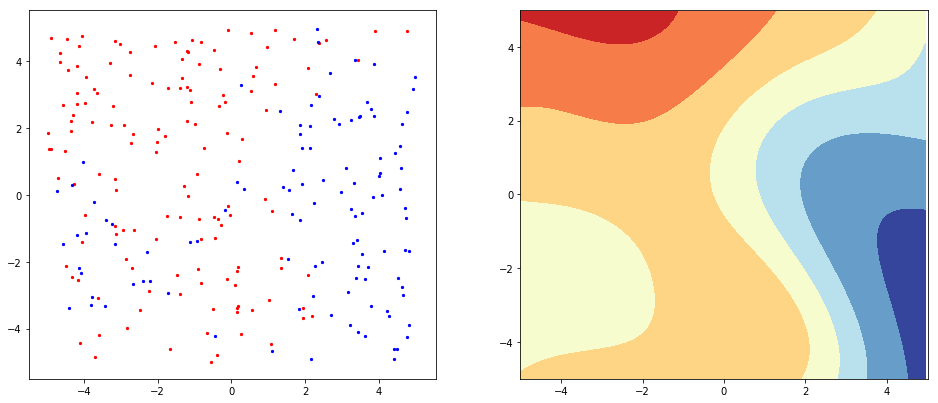

In [2]:
from ml_helper import helper
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

X, Y, TRUE_SURFACE = helper.gen_planar_samples(seed=1346)
plt.figure()
ax_l = plt.subplot(1, 2, 1)
helper.plot_red_blue(X, Y, ax=ax_l)
ax_r = plt.subplot(1, 2, 2)
helper.plot_decision_surface(TRUE_SURFACE, ax=ax_r)
plt.gcf().set_size_inches(14, 6)

In [3]:
from sklearn.ensemble import RandomForestClassifier
def train_random_forest(max_depth=1, num_trees=10):
    model = RandomForestClassifier(max_depth=max_depth, n_estimators=num_trees).fit(X, Y)
    helper.plot_decision_surface(model.predict_proba)
    helper.plot_red_blue(X, Y, ax=plt.gca())
    plt.gcf().set_size_inches(7, 6)
    
interact(
    train_random_forest,
    max_depth=widgets.IntSlider(min=1, max=5, value=2),
    num_trees=widgets.IntSlider(min=1, max=50, value=10),
);

interactive(children=(IntSlider(value=2, description='max_depth', max=5, min=1), IntSlider(value=10, descripti…

In [4]:
# My backup career goal is to try and sell a print of the above to the NAC to replace the "Voice of Fire"
# Now let's look at boosted trees:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
def train_adaboost(num_classifiers=10):
    
    model = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=num_classifiers).fit(X, Y)
    
    helper.plot_decision_surface(model.predict_proba)
    helper.plot_red_blue(X, Y, ax=plt.gca())
    plt.gcf().set_size_inches(7, 6)
    
interact(
    train_adaboost,
    num_classifiers=widgets.IntSlider(min=1, max=100, value=10),
);

interactive(children=(IntSlider(value=10, description='num_classifiers', min=1), Output()), _dom_classes=('wid…

## Notes on AdaBoost

Notice how the AdaBoostClassifier actually takes another predictor as the first argument.

AdaBoosting is a general process that can be applied to arbitrary base classifiers. It's most often used with trees, however, since it needs to train very many version of a model, and only shallow trees are fast enough to train. 

You don't really want to do it with a neural net!

### Weak Learners
An important thing to note is that AdaBoost works best with "weak learners", defined as a simple model which is capable of achieving just above 50% accuracy (or just above 1/#Classes more generally). Without going into the details: if we can't do better than 50/50 out of any single learner, then aggregating them won't help!

In [5]:
# For kicks, let's see what adaboosting a linear SVM looks like...
from sklearn.svm import SVC
from warnings import filterwarnings
filterwarnings('ignore', '.*')
def train_adasvm(kernel='linear', num_classifiers=10):
    
    # adaboost needs probabilities to work
    model = AdaBoostClassifier(
        base_estimator=SVC(kernel=kernel, probability=True, gamma=2), n_estimators=num_classifiers).fit(X, Y)
    
    helper.plot_decision_surface(model.predict_proba)
    helper.plot_red_blue(X, Y, ax=plt.gca())
    plt.gcf().set_size_inches(7, 6)
    
interact(
    train_adasvm,
    num_classifiers=widgets.IntSlider(min=1, max=20, value=3),
    kernel=widgets.RadioButtons(options=['linear', 'rbf'])
);

interactive(children=(RadioButtons(description='kernel', options=('linear', 'rbf'), value='linear'), IntSlider…

### For the linear SVM
This washed out mess is an illustration of why domain knowledge is important: the random samples are not linearly separable, and red and blue are generated in equal amounts. The end result is that trying to layer linear models results in every point being labelled 50/50. The linear classifier is simply not up to the task!
### For the RBF SVM
Think a little bit about how it works using the "shining light" analogy from the Decision Surfaces notebook. This is a potentially-useful classifier! (In any case, someone wrote a thesis about it: https://arxiv.org/pdf/0812.2575.pdf) though it does appear to suffer from "washout" as well.